# Introduction - A Prediction: 
**The use of the DenseNet model for multiclassification of the conditions in the NIH chest x-ray dataset.**
This is a continuation from the analysis of this data [https://www.kaggle.com/code/naijaoracle/nih-chest-x-ray-dataset-analysis](http://)

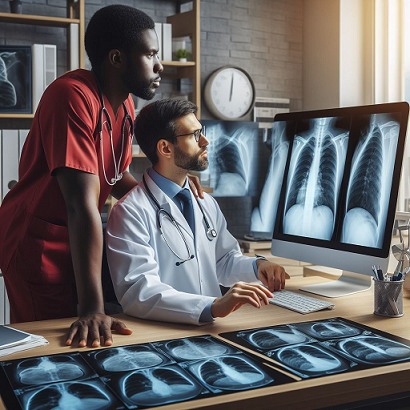

## File loading

In [85]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore', category=FutureWarning) # Suppress warnings about future library updates

There are two CSV files in this dataset: BBox_List_2017.csv and Data_Entry_2017.csv

In [86]:
#We load the datasets into pandas dataframes

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
    df2 = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide a default dataframe or exit the program

# A basic overview of the NIH chest x-ray data.

We will use some exploratory functions to see what this data looks like.
head(), describe().

In [87]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [88]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


And for the second dataframe.

In [89]:
df2.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [90]:
df2.describe()

,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN


We can see that the second dataframe has 112120 x-rays while df2 has 984, they could be combined into one dataframe, however the number of images in df2 are not statistically significant to the whole.

## Data cleaning and preprocessing

In [91]:
column_list = df.columns.tolist()
print(column_list)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


In [92]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [93]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

From calling df.head() we can see that the conditions are listed in the column 'Finding Label' which we can extract.

In [94]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Finding,Hernia,Infiltration,Mass,No,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,1,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


Split the 'Finding Labels' colmumn into separate conditions.

In [95]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
def create_disease_columns(dataframe, pathology_list):
    for pathology in pathology_list:
        dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: int(pathology in x))
    return dataframe

# Call the function with the dataframe and pathology_list
df = create_disease_columns(df, pathology_list)

In [96]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

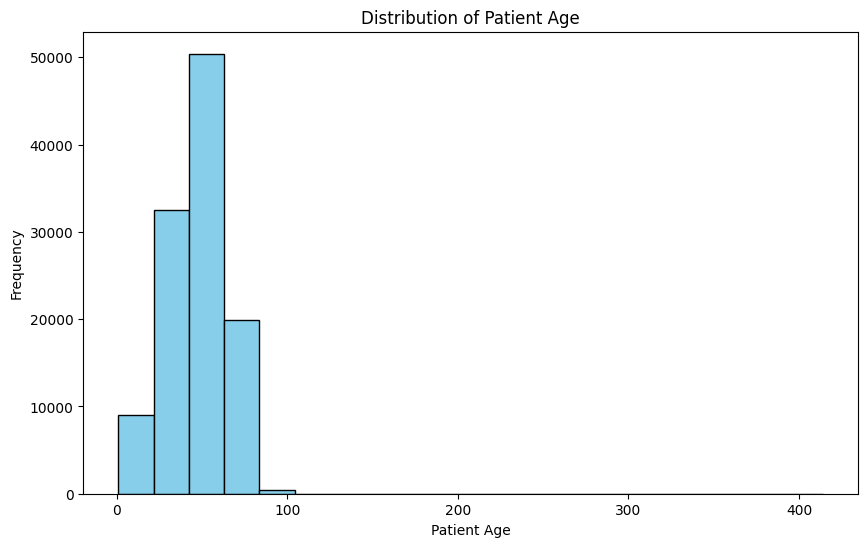

In [97]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

We can see that a majority of the patients are between the ages of 0 and 100. There are a few that are above 100 years old and  of those were above the current record of 122 years old. We can look deeper into this and make changes as there is a high chance that those are errors.

In [98]:
# Create a boolean mask for ages greater than 100
mask = df['Patient Age'] > 100

# Use the mask to filter the DataFrame
filtered_df = df[mask]

# Get the number of rows in the filtered DataFrame
num_persons = filtered_df.shape[0]

print(num_persons)

16


In [99]:
# Create a boolean mask for ages less than or equal to 100
mask = df['Patient Age'] <= 100

# Use the mask to filter the DataFrame
df = df[mask]

After removing the patients with ages above the current record of 122 years old, we can visualise the age distribution again.

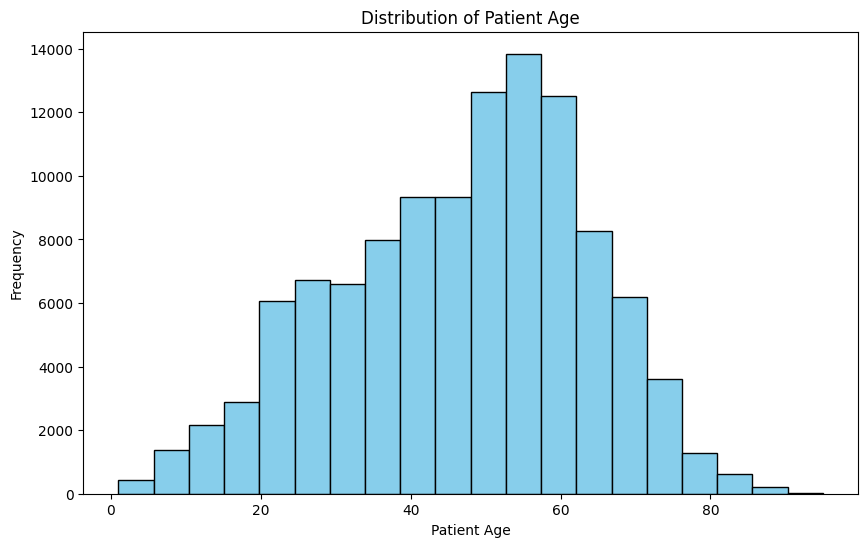

In [100]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

In [101]:
no_finding_count = df['No Finding'].sum()
print(no_finding_count)

60353


In [166]:
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for condition in pathology_list:
    print(f"{condition}: {df[condition].sum()}")

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301


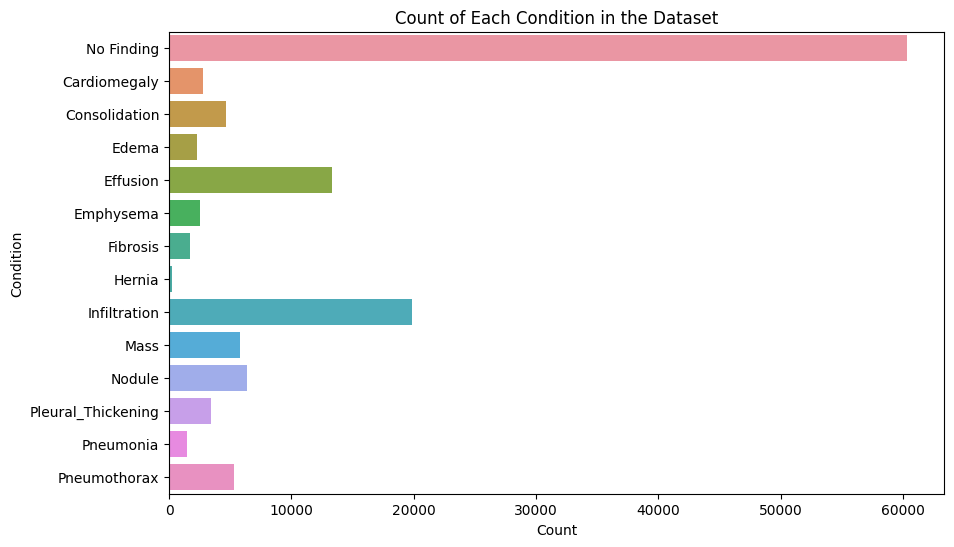

In [102]:
# Set the default palette
sns.set_palette('viridis')

# Create a list to store the counts of each condition
condition_counts = [df[pathology].sum() for pathology in pathology_list]

# Create a DataFrame from the condition counts
data = pd.DataFrame({
    'Condition': pathology_list,
    'Count': condition_counts
})

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(y='Condition', x='Count', data=data)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Count of Each Condition in the Dataset')

# Display the chart
plt.show()

## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings. 

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [103]:
# Create age groups
bins = list(range(0, 101, 10))  # Creates bins from 0 to 130 with a step of 10
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]  # Creates labels for these bins
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False)

# Calculate % of total per age group
total_patients = df.shape[0]
df_total = df['Age Group'].value_counts().sort_index() / total_patients * 100

# Calculate % of no findings per age group
df_no_findings = df[df['No Finding'] == 1].groupby('Age Group').size() / df.groupby('Age Group').size() * 100

# Combine both series into a dataframe
age_analysis_df = pd.concat([df_total, df_no_findings], axis=1)
age_analysis_df.columns = ['% of Total', '% of No Findings']

# Print the dataframe
print(age_analysis_df)

           % of Total  % of No Findings
Age Group                              
0-9          1.251516         59.871703
10-19        4.835688         58.254935
20-29       11.416185         57.462103
30-39       14.551666         58.413535
40-49       19.384679         55.851088
50-59       24.446942         51.988616
60-69       17.191180         48.988169
70-79        5.923963         47.718717
80-89        0.940198         42.884250
90-99        0.057982         38.461538


We see that there the trend is for the number of x-rays with 'No findings' to decrease with age. About 50.4% of those <10 have no finding dropping off to 28.4% with no findings in the nineties, this is in keeping with what we may expect as health issues tend to increase with age.

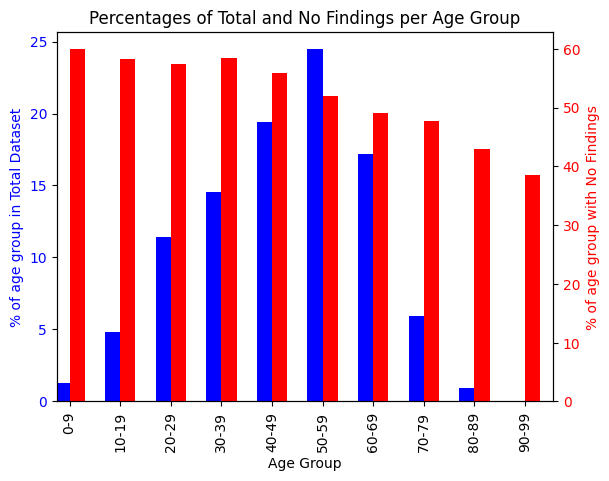

In [104]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot % of Total
age_analysis_df['% of Total'].plot(kind='bar', color='blue', ax=ax1, width=0.3, position=1)
ax1.set_ylabel('% of age group in Total Dataset', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same plot
ax2 = ax1.twinx()

# Plot % of No Findings on the second y-axis
age_analysis_df['% of No Findings'].plot(kind='bar', color='red', ax=ax2, width=0.3, position=0)
ax2.set_ylabel('% of age group with No Findings', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the x-axis label
ax1.set_xlabel('Age Group')

# Set the plot title
plt.title('Percentages of Total and No Findings per Age Group')

# Show the plot
plt.show()

In [105]:
# Calculate the statistical summary for 'Follow-up #' for each age group
follow_up_summary = df.groupby('Age Group', observed=True)['Follow-up #'].describe()

# Print the summary
print(follow_up_summary)

             count       mean        std  min  25%  50%   75%    max
Age Group                                                           
0-9         1403.0   7.114754  13.337775  0.0  0.0  1.0   7.0   80.0
10-19       5421.0   8.788046  13.999377  0.0  0.0  3.0  11.0  157.0
20-29      12798.0  10.170574  18.075101  0.0  0.0  3.0  11.0  151.0
30-39      16313.0   8.825783  15.235733  0.0  0.0  3.0  11.0  156.0
40-49      21731.0   7.827389  13.920925  0.0  0.0  3.0   9.0  142.0
50-59      27406.0   9.112895  17.577098  0.0  0.0  3.0  10.0  183.0
60-69      19272.0   7.872042  12.849892  0.0  0.0  3.0   9.0  113.0
70-79       6641.0   7.657883  13.958591  0.0  0.0  3.0   8.0  118.0
80-89       1054.0   6.272296   9.555300  0.0  0.0  2.0   8.0   54.0
90-99         65.0   6.415385   6.573841  0.0  1.0  5.0  11.0   23.0


Patient gender doesn't seem to have much on an impact on wether there are findings or not. This may not be surprising information.

In [106]:
gender_analysis = df.groupby('Patient Gender')['No Finding'].mean()
print(gender_analysis)

Patient Gender
F    0.542008
M    0.535561
Name: No Finding, dtype: float64


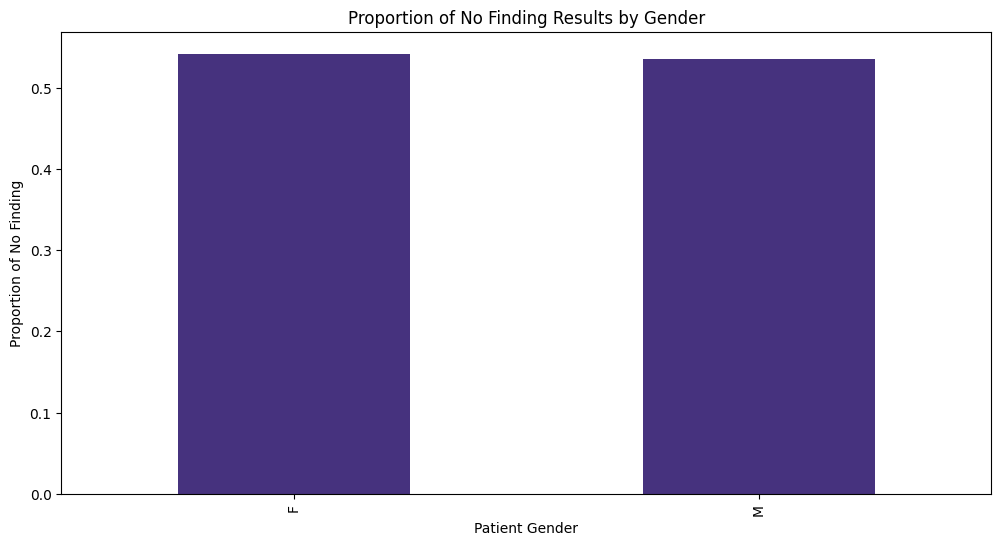

In [107]:
# Set the color palette
sns.set_palette('viridis')

# Create a bar plot
plt.figure(figsize=(12,6))
gender_analysis.plot(kind='bar')

# Set the plot labels and title
plt.xlabel('Patient Gender')
plt.ylabel('Proportion of No Finding')
plt.title('Proportion of No Finding Results by Gender')

# Show the plot
plt.show()

In [108]:
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'No Finding', 'Cardiomegaly', 'Consolidation',
       'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Age Group'],
      dtype='object')

# Machine Learning Section

Now that we have had a look at the data we are working with, we can begin to build our model. Remember:
- PyTorch
- DenseNet
So we start by importing the necessary libraries and take it from there.

In [121]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models,transforms
from torchvision.models import densenet121
from torchvision.models.densenet import DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from PIL import Image
from tqdm import tqdm
import glob

**Training data and test data**
Our default using 80% of the data for training, the remaining 20% set aside for testing

In [122]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [123]:
# Load the images
root_folder = "/kaggle/input/data/"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide default paths or exit the program

In [124]:
# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_paths, transform=None):
        """
        Custom dataset class for Chest X-ray images.

        Arguments:
            dataframe (pd.DataFrame): DataFrame containing image labels and conditions.
            image_paths (list): List of file paths to the X-ray images.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.dataframe) # Get and return an integer of the number of samples in the dataset

    def __getitem__(self, idx):
        """
        __get item__ prepares the samples from the dataset one at a time.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, labels) where
                image (PIL.Image.Image): X-ray image.
                labels (np.ndarray): Array of condition labels for the image.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx, 5:-1].values.astype('float32')  # Assuming columns 5 to -1 are the condition columns

        if self.transform:
            image = self.transform(image)

        return image, labels

In [125]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [126]:
# Create datasets
train_dataset = ChestXRayDataset(train_df, image_paths, transform=transform)
val_dataset = ChestXRayDataset(val_df, image_paths, transform=transform)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [127]:
#Select the device to run the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This is where we load **DenseNet-121**

In [128]:
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore all UserWarnings
# Define the DenseNet-121 model for transfer learning
# Using a pre-trained model for feature extraction
model = models.densenet121(pretrained=True)

A lot of adjustments and readjustments done here - tuning

In [129]:
# Modify the classifier for multi-label classification
# Replace the final layer with a binary classification layer
model.classifier = nn.Sequential(
    nn.Linear(1024, len(pathology_list)),
    nn.Sigmoid()
)

In [130]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) #Tune and tune

## Model training

In [131]:
# Initialize variables to track the best validation metric
best_val_metric = float('inf')
best_epoch = -1

def calculate_metrics(outputs, labels):
    # Convert NumPy array to PyTorch tensor
    outputs_tensor = torch.from_numpy(outputs)

    # Convert probabilities to binary predictions
    predictions = (outputs_tensor > 0.5).float()

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return accuracy, precision, recall, f1

In [132]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, val_loader, criterion, device, best_val_metric, epoch):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        all_predictions = []
        all_labels = []
        val_loader_iter = tqdm(val_loader, desc='Validation', leave=False)
        for inputs, labels in val_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels)

            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

        val_loss /= len(val_loader)

        if val_loss < best_val_metric:  # or other metrics like accuracy, precision, recall, etc.
            best_val_metric = val_loss

            # Save the current best model
            torch.save(model.state_dict(), 'NIH_chest_xray_best_model.pth')
            print(f'Saved the model at epoch {epoch + 1} with validation loss: {val_loss}')

        all_predictions = np.vstack(all_predictions)
        all_labels = np.vstack(all_labels)
        accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_labels)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

num_epochs = 10
best_val_metric = float('inf')

model.to(device)

for epoch in range(num_epochs):
    train_epoch(model, train_loader, optimizer, criterion, device)
    evaluate(model, val_loader, criterion, device, best_val_metric, epoch)

Saved the model at epoch 1 with validation loss: 0.2094709873199463
Epoch 1/10, Loss: 0.2094709873199463, Accuracy: 0.5357031354533696, Precision: 0.2523191299597735, Recall: 0.4619291293139933, F1: 0.32636707054796826


Saved the model at epoch 2 with validation loss: 0.208779439330101
Epoch 2/10, Loss: 0.208779439330101, Accuracy: 0.5393158199901877, Precision: 0.2519458523352196, Recall: 0.46523796698857295, F1: 0.3268751273339057


Saved the model at epoch 3 with validation loss: 0.20876780152320862
Epoch 3/10, Loss: 0.20876780152320862, Accuracy: 0.5290129789037064, Precision: 0.2521984419946271, Recall: 0.45573467738832674, F1: 0.3247074404442039


Saved the model at epoch 4 with validation loss: 0.20867608487606049
Epoch 4/10, Loss: 0.20867608487606049, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


Saved the model at epoch 5 with validation loss: 0.20948119461536407
Epoch 5/10, Loss: 0.20948119461536407, Accuracy: 0.534588109361759, Precision: 0.3283558395391643, Recall: 0.4609287830402832, F1: 0.3258714951399028


Saved the model at epoch 6 with validation loss: 0.20874878764152527
Epoch 6/10, Loss: 0.20874878764152527, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


Saved the model at epoch 7 with validation loss: 0.20872969925403595
Epoch 7/10, Loss: 0.20872969925403595, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


Saved the model at epoch 8 with validation loss: 0.20890013873577118
Epoch 8/10, Loss: 0.20890013873577118, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


Saved the model at epoch 9 with validation loss: 0.20876727998256683
Epoch 9/10, Loss: 0.20876727998256683, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


Saved the model at epoch 10 with validation loss: 0.20874427258968353
Epoch 10/10, Loss: 0.20874427258968353, Accuracy: 0.5404308460817984, Precision: 0.2519487731127371, Recall: 0.4661998384056019, F1: 0.3271146819132943


In [133]:
# After training loop, load the best model
if best_epoch != -1:
    print(f"Best model found at epoch {best_epoch + 1}. Loading the best model...")
    best_model_path = 'NIH_chest_xray_best_model.pth' # The best performing model was saved at torch.save(model.state_dict(), 'NIH_chest_xray_best_model.pth')
    best_model = models.densenet121(pretrained=True)
    best_model.classifier = nn.Sequential(
        nn.Linear(1024, len(pathology_list)),
        nn.Sigmoid()
    )
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()
else:
    print("No improvement in the validation metric. Using the last model.")

No improvement in the validation metric. Using the last model.


# Performance visualisation

To visualise the performance of our model's performance based on our metrics.

In [134]:
# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

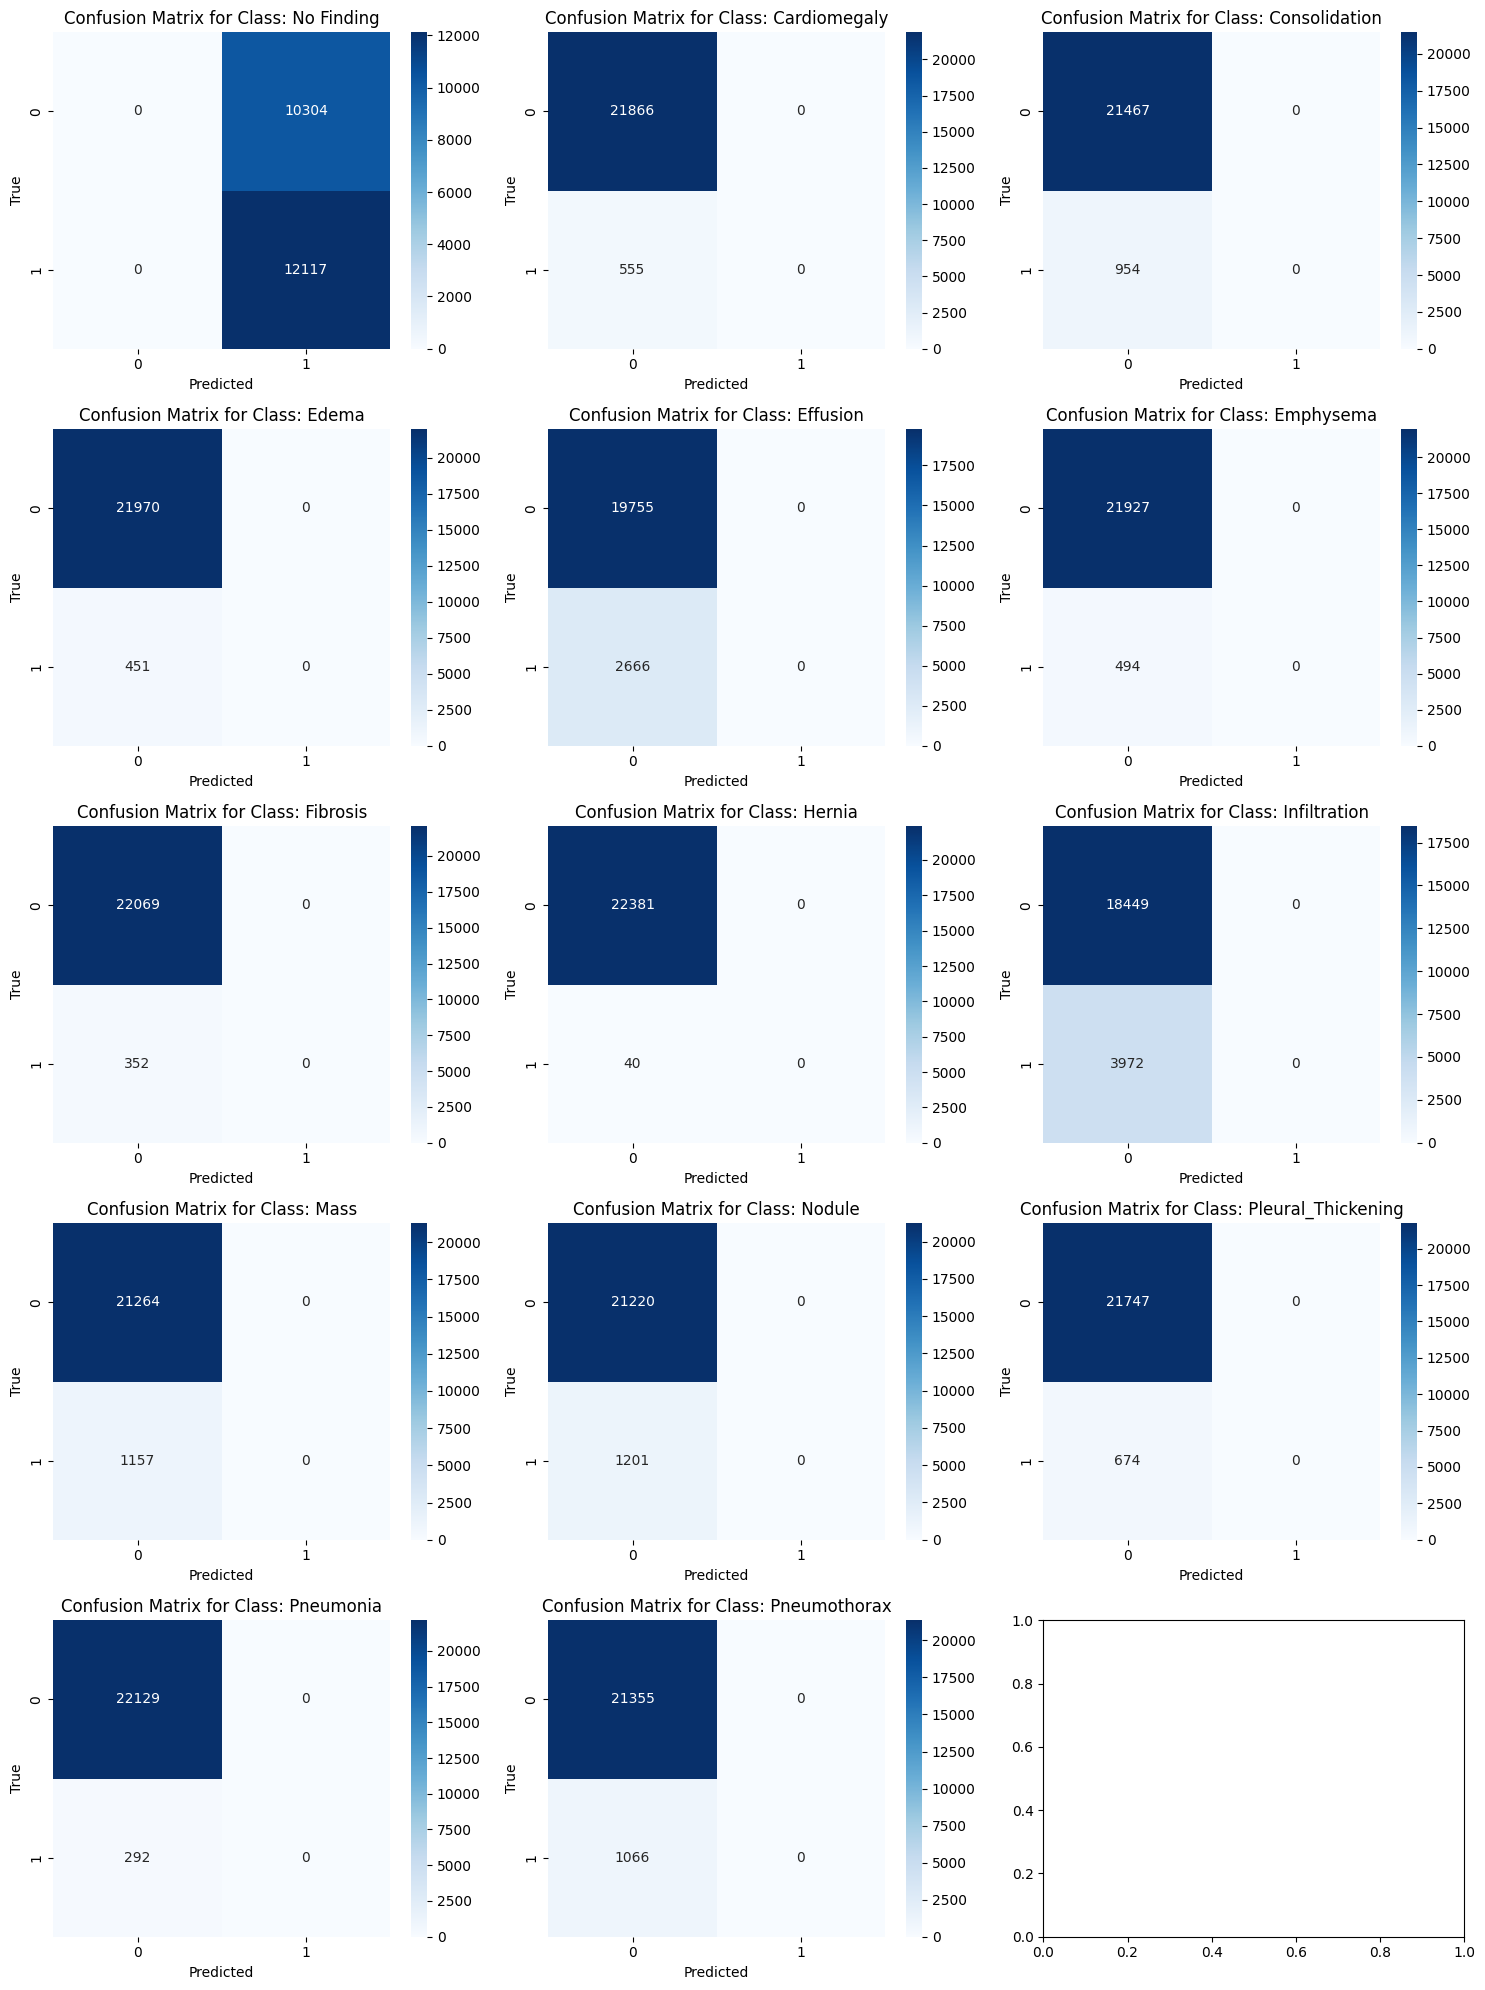

In [153]:
# Compute confusion matrix
cm = multilabel_confusion_matrix(all_labels, all_predictions)

fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # Adjust as needed

for i, (cn, ax) in enumerate(zip(pathology_list, axs.flatten())):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix for Class: {cn}')

plt.tight_layout()
plt.show()

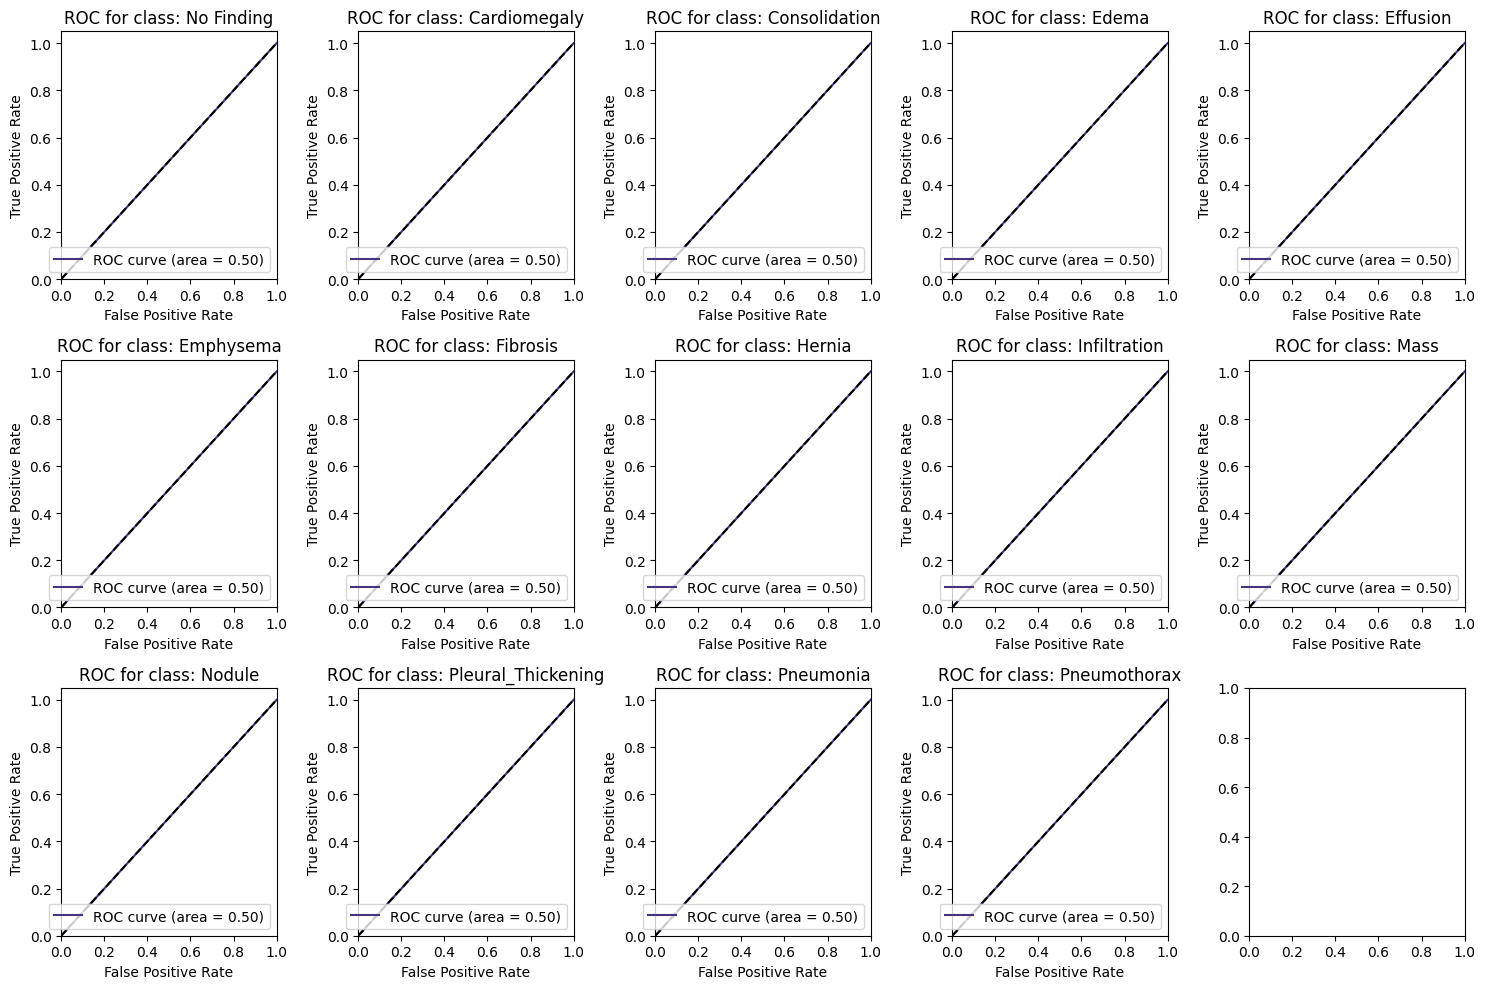

In [162]:
# Define the number of rows and columns
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class in a subplot
    axs[i // n_cols, i % n_cols].plot(fpr[i], tpr[i], label='ROC curve (area = %.2f)' % roc_auc[i])
    axs[i // n_cols, i % n_cols].plot([0, 1], [0, 1], 'k--')
    axs[i // n_cols, i % n_cols].set_xlim([0.0, 1.0])
    axs[i // n_cols, i % n_cols].set_ylim([0.0, 1.05])
    axs[i // n_cols, i % n_cols].set_xlabel('False Positive Rate')
    axs[i // n_cols, i % n_cols].set_ylabel('True Positive Rate')
    axs[i // n_cols, i % n_cols].set_title('ROC for class: %s' % pathology_list[i])
    axs[i // n_cols, i % n_cols].legend(loc="lower right")

plt.tight_layout()
plt.show()

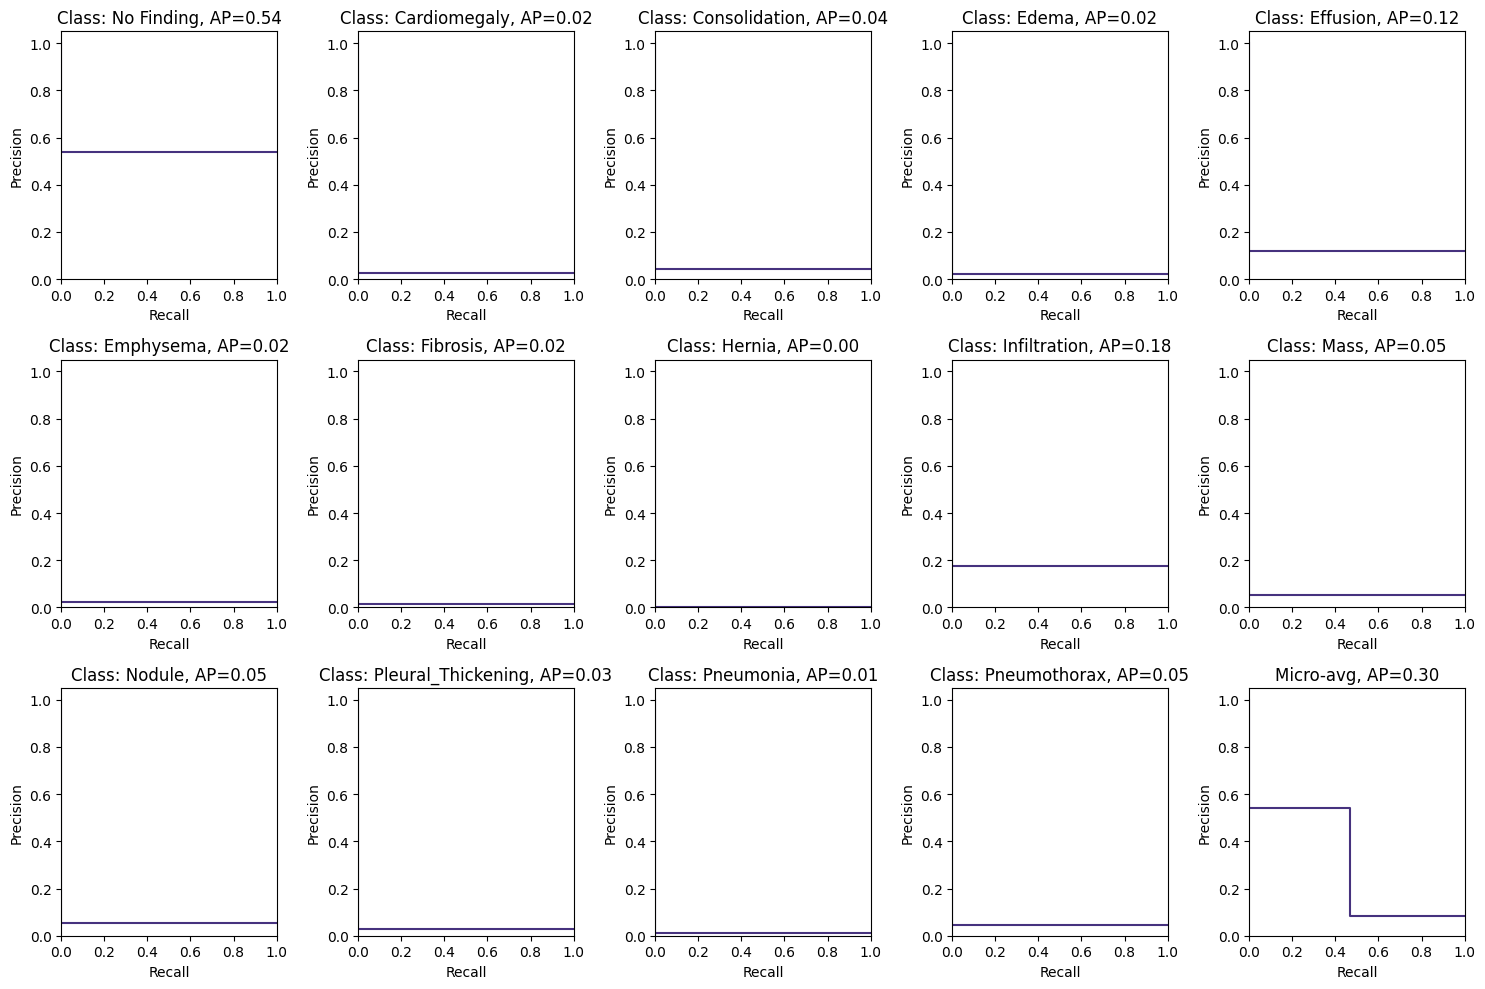

In [161]:
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(14):
    precision[i], recall[i], _ = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

    # Plot Precision-Recall curve for each class in a subplot
    axs[i // n_cols, i % n_cols].step(recall[i], precision[i], where='post')
    axs[i // n_cols, i % n_cols].set_xlabel('Recall')
    axs[i // n_cols, i % n_cols].set_ylabel('Precision')
    axs[i // n_cols, i % n_cols].set_ylim([0.0, 1.05])
    axs[i // n_cols, i % n_cols].set_xlim([0.0, 1.0])
    axs[i // n_cols, i % n_cols].set_title('Class: {}, AP={:.2f}'.format(pathology_list[i], average_precision[i]))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Plot micro-averaged Precision-Recall curve in a subplot
axs[14 // n_cols, 14 % n_cols].step(recall['micro'], precision['micro'], where='post')
axs[14 // n_cols, 14 % n_cols].set_xlabel('Recall')
axs[14 // n_cols, 14 % n_cols].set_ylabel('Precision')
axs[14 // n_cols, 14 % n_cols].set_ylim([0.0, 1.05])
axs[14 // n_cols, 14 % n_cols].set_xlim([0.0, 1.0])
axs[14 // n_cols, 14 % n_cols].set_title('Micro-avg, AP={:.2f}'.format(average_precision["micro"]))

plt.tight_layout()
plt.show()


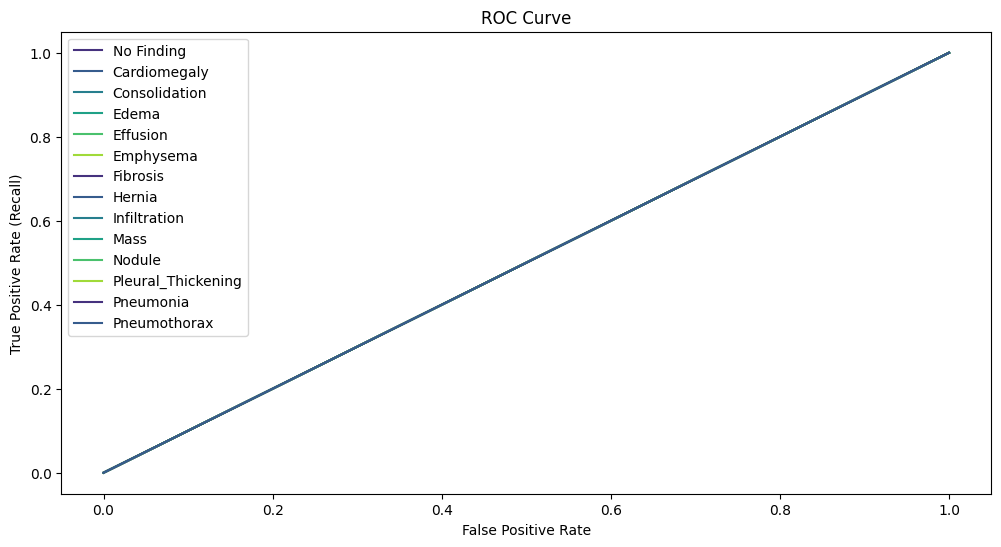

In [165]:
def plot_roc_curve(y_true, y_scores, classes):
    plt.figure(figsize=(12,6))
#     plt.figure(figsize=(len(classes), len(classes)))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(all_labels, all_predictions, pathology_list)

In [160]:
classification_rep = classification_report(all_labels, all_predictions, target_names=pathology_list)
print(classification_rep)

                    precision    recall  f1-score   support

        No Finding       0.54      1.00      0.70     12117
      Cardiomegaly       0.00      0.00      0.00       555
     Consolidation       0.00      0.00      0.00       954
             Edema       0.00      0.00      0.00       451
          Effusion       0.00      0.00      0.00      2666
         Emphysema       0.00      0.00      0.00       494
          Fibrosis       0.00      0.00      0.00       352
            Hernia       0.00      0.00      0.00        40
      Infiltration       0.00      0.00      0.00      3972
              Mass       0.00      0.00      0.00      1157
            Nodule       0.00      0.00      0.00      1201
Pleural_Thickening       0.00      0.00      0.00       674
         Pneumonia       0.00      0.00      0.00       292
      Pneumothorax       0.00      0.00      0.00      1066

         micro avg       0.54      0.47      0.50     25991
         macro avg       0.04      0.0

Model is far too biased towards no findings.